In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  #visualisation
import seaborn as sns
import os
import json   # to save the project data
import pickle  # to save the model
import re

#standardization and normalization
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#machine learning model import
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

#model training and hyper parameter tuning
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

#Evaluation parameters
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

#feature selection techniques
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option("display.max_rows",None)

### Problem statement

### Data Gathering and validation

In [3]:
df=pd.read_csv("train.csv",sep='[,]',engine='python')
df.head()

,"""Loan_ID",Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,"Loan_Status"""
0,"""LP001002",Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,"Y"""
1,"""LP001003",Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,"N"""
2,"""LP001005",Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,"Y"""
3,"""LP001006",Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,"Y"""
4,"""LP001008",Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,"Y"""


### EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   "Loan_ID           614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status"       614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


<AxesSubplot:>

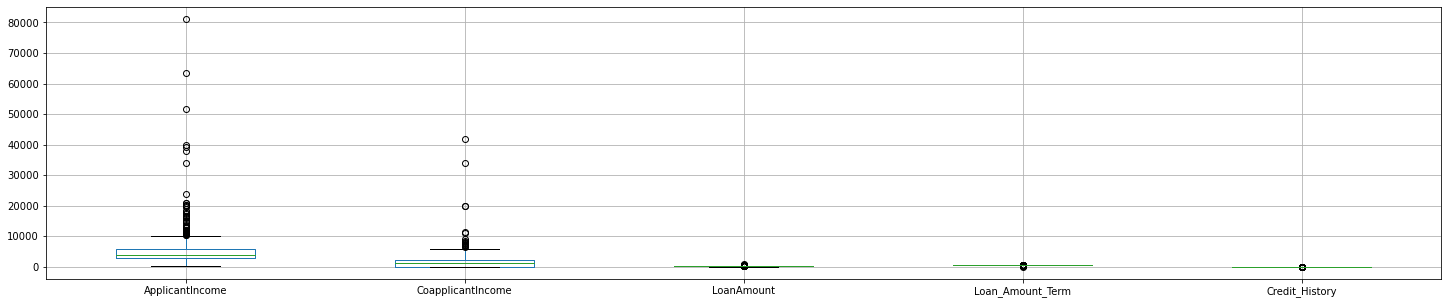

In [5]:
plt.figure(figsize=(25,5))
df.boxplot()

In [6]:
df.isna().sum()

"Loan_ID              0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status"          0
dtype: int64

<AxesSubplot:>

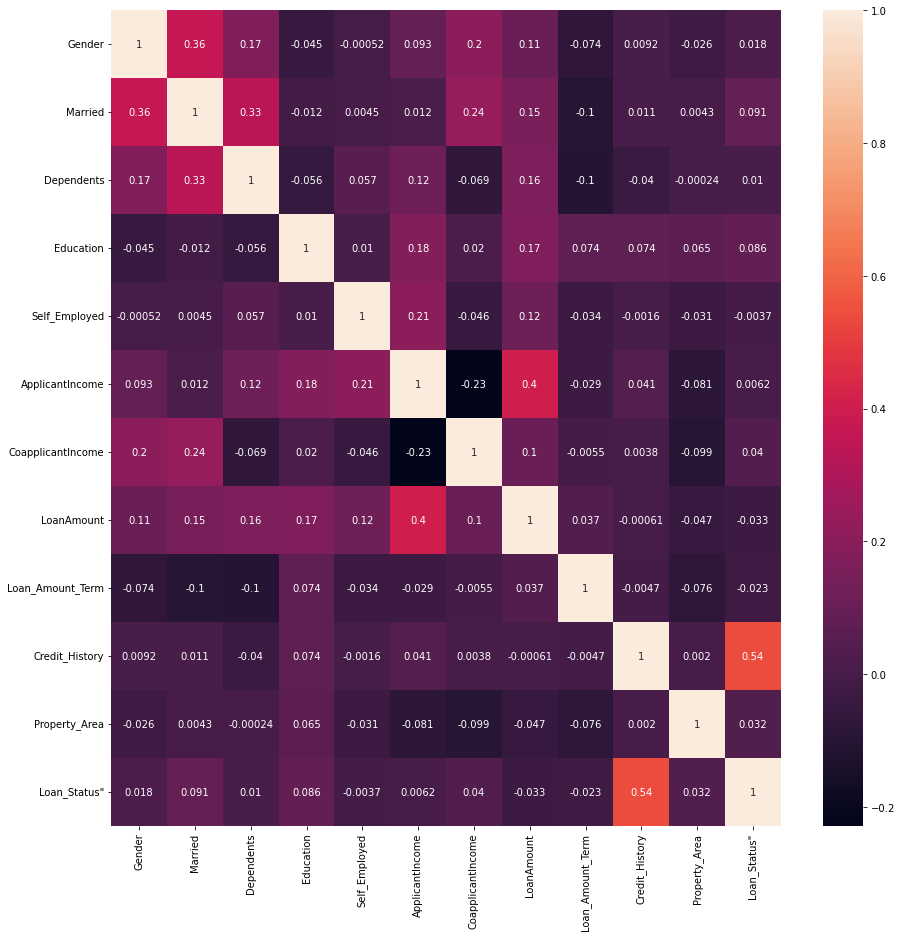

In [56]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True)

### Feature Engineering

##### "Loan_ID

In [7]:
#have no effect on the target column since contains all unique values
df=df.drop('"Loan_ID',axis=1)

##### Gender

In [8]:
df["Gender"].fillna(df["Gender"].mode()[0],inplace=True)

In [9]:
df["Gender"].isna().sum()

0

In [10]:
df["Gender"].replace({"Male":1,"Female":0},inplace=True)

In [11]:
df["Gender"].dtypes

dtype('int64')

##### Married

In [12]:
df["Married"].fillna(df["Married"].mode()[0],inplace=True)

In [13]:
df["Married"].isna().sum()

0

In [14]:
df["Married"].replace({"Yes":1,"No":0},inplace=True)

In [15]:
df["Married"].dtypes

dtype('int64')

##### Dependents

In [16]:
df["Dependents"].unique()

array(['0', '1', '2', '3+', nan], dtype=object)

In [17]:
df["Dependents"]=df["Dependents"].str.replace("+","")

In [18]:
df["Dependents"].fillna(df["Dependents"].median(),inplace=True)

In [19]:
df["Dependents"]=df["Dependents"].astype(float)

##### Education

In [20]:
df["Education"].unique()

array(['Graduate', 'Not Graduate'], dtype=object)

In [21]:
df["Education"].replace({'Graduate':1, 'Not Graduate':0},inplace=True)

##### Self_Employed

In [22]:
df["Self_Employed"].unique()

array(['No', 'Yes', nan], dtype=object)

In [23]:
df["Self_Employed"].fillna(df["Self_Employed"].mode()[0],inplace=True)

In [24]:
df["Self_Employed"].replace({'No':0, 'Yes':1},inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Dependents         614 non-null    float64
 3   Education          614 non-null    int64  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status"       614 non-null    object 
dtypes: float64(5), int64(5), object(2)
memory usage: 57.7+ KB


##### ApplicantIncome

In [26]:
df["ApplicantIncome"].describe()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

In [27]:
df["ApplicantIncome"]=np.where(df["ApplicantIncome"]>10000,df["ApplicantIncome"].mean(),df["ApplicantIncome"])

<AxesSubplot:>

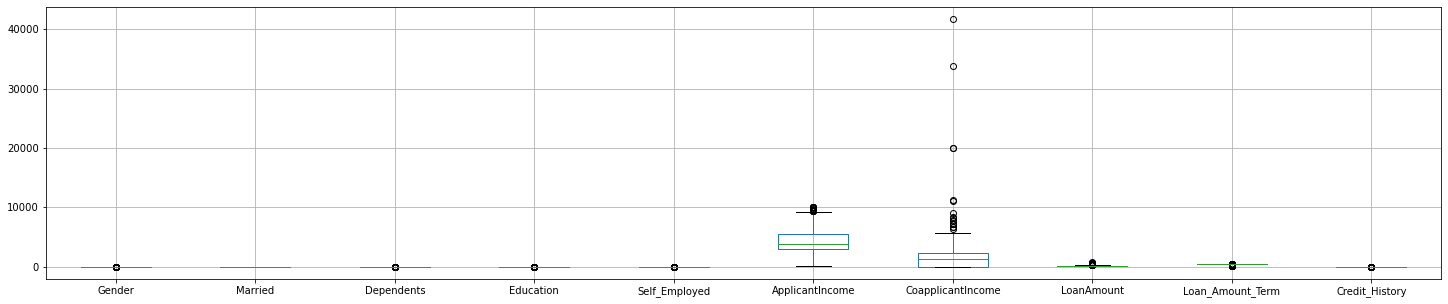

In [28]:
plt.figure(figsize=(25,5))
df.boxplot()

##### CoapplicantIncome

In [29]:
df["CoapplicantIncome"].describe()

count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64

In [30]:
df["CoapplicantIncome"]=np.where(df["CoapplicantIncome"]>6000,df["CoapplicantIncome"].median(),df["CoapplicantIncome"])

##### LoanAmount

In [31]:
df["LoanAmount"].fillna(df["LoanAmount"].median(),inplace=True)

In [32]:
df["LoanAmount"].isna().sum()

0

##### Loan_Amount_Term

In [33]:
df["Loan_Amount_Term"].unique()

array([360., 120., 240.,  nan, 180.,  60., 300., 480.,  36.,  84.,  12.])

In [34]:
df["Loan_Amount_Term"].fillna(df["Loan_Amount_Term"].median(),inplace=True)

##### Credit_History

In [35]:
df["Credit_History"].unique()

array([ 1.,  0., nan])

In [36]:
df["Credit_History"].fillna(df["Credit_History"].median(),inplace=True)

##### Property_Area

In [37]:
df["Property_Area"].unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

In [38]:
df["Property_Area"]=df["Property_Area"].replace({'Urban':2, 'Rural':0, 'Semiurban':1})

##### Loan_Status"

In [39]:
df['Loan_Status"'].unique()

array(['Y"', 'N"'], dtype=object)

In [40]:
df['Loan_Status"']=df['Loan_Status"'].replace({'Y"':1, 'N"':0})

### Model selection and model training

In [45]:
x=df.drop('Loan_Status"',axis=1)
y=df['Loan_Status"']

In [47]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0,stratify=y)

### KNN Classifier

In [48]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(x_train,y_train)

KNeighborsClassifier()

In [52]:
# testing data

yp_test=knn_clf.predict(x_test)
confu_matrix=confusion_matrix(y_test,yp_test)
Accuracy=accuracy_score(y_test,yp_test)
classify_report=classification_report(y_test,yp_test)
print("Test Accuracy",Accuracy)

# training data

yp_train=knn_clf.predict(x_train)
confu_matrix=confusion_matrix(y_train,yp_train)
Accuracy=accuracy_score(y_train,yp_train)
classify_report=classification_report(y_train,yp_train)

print("Train Accuracy",Accuracy)


Test Accuracy 0.5934959349593496
Train Accuracy 0.7311608961303462


#### KNN hyper parameter tuning

In [58]:
model_knn=KNeighborsClassifier()
hypo={"n_neighbors":np.arange(3,25),
     "p":[1,2]}
gridcv=GridSearchCV(model_knn,hypo,cv=5)
gridcv.fit(x_train,y_train)
gridcv.best_params_

{'n_neighbors': 11, 'p': 1}

In [59]:
knn=KNeighborsClassifier(n_neighbors=11,p=1)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=11, p=1)

In [60]:
#Evaluation after hyperparameter tuning
# testing data

yp_test=knn.predict(x_test)
confu_matrix=confusion_matrix(y_test,yp_test)
Accuracy=accuracy_score(y_test,yp_test)
classify_report=classification_report(y_test,yp_test)
print("Test Accuracy",Accuracy)

# training data

yp_train=knn.predict(x_train)
confu_matrix=confusion_matrix(y_train,yp_train)
Accuracy=accuracy_score(y_train,yp_train)
classify_report=classification_report(y_train,yp_train)

print("Train Accuracy",Accuracy)


Test Accuracy 0.6666666666666666
Train Accuracy 0.7189409368635438


### Logistic Regression

In [63]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0,stratify=y)
logy=LogisticRegression()
logy.fit(x_train,y_train)

LogisticRegression()

In [65]:
print("train accuracy",logy.score(x_train,y_train),"test accuracy",logy.score(x_test,y_test))

train accuracy 0.8085539714867617 test accuracy 0.8048780487804879


### Decision Tree

In [66]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0,stratify=y)
DT = DecisionTreeClassifier()
DT.fit(x_train,y_train)

DecisionTreeClassifier()

In [67]:
print("train accuracy",DT.score(x_train,y_train),"test accuracy",DT.score(x_test,y_test))

train accuracy 1.0 test accuracy 0.7073170731707317


#### DT_hyperparameter tuning

In [71]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0,stratify=y)

In [73]:
model= DecisionTreeClassifier()
hyper_p = {"criterion" :['gini',"entropy"],
              "max_depth":np.arange(2,8),
              "min_samples_split":np.arange(3,20),
              "min_samples_leaf":np.arange(3,15),}
grid=GridSearchCV(model,hyper_p,cv=5)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_split': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])})

In [74]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 3}

In [77]:
dt_h= DecisionTreeClassifier(criterion="gini",max_depth=2,min_samples_leaf=3,min_samples_split=3,random_state=0)
dt_h.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=3, min_samples_split=3,
                       random_state=0)

In [78]:
print("train accuracy",dt_h.score(x_train,y_train),"test accuracy",dt_h.score(x_test,y_test))

train accuracy 0.8085539714867617 test accuracy 0.8130081300813008


In [80]:
x.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,0,0.0,1,0,5849.0,0.0,128.0,360.0,1.0,2
1,1,1,1.0,1,0,4583.0,1508.0,128.0,360.0,1.0,0


### conclusion

In [ ]:
KNN classifier (raw data): Train Accuracy 0.7311608961303462 Test Accuracy 0.5934959349593496 
KNN classifier hypertuned: Train Accuracy 0.7189409368635438 Test Accuracy 0.6666666666666666
Logistic regression (raw): train accuracy 0.8085539714867617 test accuracy 0.8048780487804879
DT classifier (raw data) : train accuracy 1.0                test accuracy 0.7073170731707317
DT classifier hypertuned : train accuracy 0.8085539714867617 test accuracy 0.8130081300813008

Hypertuned DT model is giving better accuracy compared to other models, so proceeded for deployement


### feature selection

In [106]:
arr=dt_h.feature_importances_
col=x.columns
df_f=pd.DataFrame(arr,index=col)

In [116]:
df_f

,0
Gender,0.000000
Married,0.000000
Dependents,0.000000
Education,0.000000
Self_Employed,0.000000
ApplicantIncome,0.000000
CoapplicantIncome,0.000000
LoanAmount,0.010366
Loan_Amount_Term,0.000000
Credit_History,0.961317


In [ ]:
#considering the results of the embedded method only 3 features are relevant

### Revised Data

In [112]:
x_new=df[["LoanAmount","Credit_History","Property_Area"]]
x_new.head()

,LoanAmount,Credit_History,Property_Area
0,128.0,1.0,2
1,128.0,1.0,0
2,66.0,1.0,2
3,120.0,1.0,2
4,141.0,1.0,2


### DT model Training

In [113]:
x_train,x_test,y_train,y_test = train_test_split(x_new,y,test_size=0.2,random_state=0,stratify=y)

In [114]:
dt_new= DecisionTreeClassifier(criterion="gini",max_depth=2,min_samples_leaf=3,min_samples_split=3,random_state=0)
dt_new.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=3, min_samples_split=3,
                       random_state=0)

### Evaluation after feature selection

In [115]:
print("train accuracy",dt_new.score(x_train,y_train),"test accuracy",dt_new.score(x_test,y_test))

train accuracy 0.8085539714867617 test accuracy 0.8130081300813008


In [ ]:
# Accuracy is same after dropping the redendunt feature

### creating json and pickle files for deployement

In [117]:
project_data= {"Gender_values":{"Male":1,"Female":0},
                "Married_values":{"Yes":1,"No":0},
                "Education_values":{'Graduate':1, 'Not Graduate':0},
                "Self_Employed_values":{"Yes":1,"No":0},
                "Property_Area_values":{'Urban':2, 'Rural':0, 'Semiurban':1},
               "columns":list(x.columns)
              }

In [120]:
with open ("project_data.json","w") as file:
    json.dump(project_data,file)

In [119]:
with open ("DTModel.pkl","wb") as file:
    pickle.dump(dt_new,file)